In [1]:
%%capture
! pip install --quiet "pandas" "torch" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "lightning-bolts" "torch-lr-finder" "grad-cam" "gradio" "torchinfo" "torchsummary"

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512
        self.nc = nc

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=1)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), self.nc, 32, 32)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim, nc):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim, nc = nc)
        self.decoder = ResNet18Dec(z_dim=z_dim, nc = nc)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, z, mean, logvar
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [3]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader 
from torchvision import datasets, transforms 
from torchvision.datasets import CIFAR10
import numpy as np

class VAE_PL(pl.LightningModule):
    def __init__(self, latent_dim=256, nc = 4):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.VAE = VAE(z_dim = latent_dim, nc = nc)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_hat, z, mu, log_var = self.VAE(x)
        
        std = torch.exp(log_var / 2)
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [5]:
from torch.utils.data import Dataset

torch.manual_seed(1)

class MyDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image2 = torch.full((1, 32, 32), 0)
        for row in range(32):
            image2[0][row][label] = 1
        final_img = torch.cat((image, image2), 0)

        final_img = np.array(final_img)
        return (final_img, label)
    
class CustomCifar10DataModule(pl.LightningDataModule):
    def __init__(self, PATH_DATASETS, batch_size, num_workers = 2):
        # Initialize the class. Set up the datadir, image dims, and num classes
        super().__init__()
        self.BATCH_SIZE = batch_size
        self.NUM_WORKERS = num_workers
        self.train_transforms = transforms.Compose(
            [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262))
            ]
        )
        self.data_dir = PATH_DATASETS
        
        self.test_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262))
            ]
        )
        self.val_transforms = self.test_transforms
        self.prepare_data()
        self.setup()
        
    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar10_full = CIFAR10(self.data_dir, train=True, transform=self.train_transforms)
            self.train_dataset, self.val_dataset = random_split(cifar10_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.test_dataset = CIFAR10(self.data_dir, train=False, transform=self.test_transforms)

    def train_dataloader(self):
        return DataLoader(MyDataset(self.train_dataset), batch_size=self.BATCH_SIZE, num_workers=self.NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(MyDataset(self.val_dataset), batch_size=self.BATCH_SIZE, num_workers=self.NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(MyDataset(self.test_dataset), batch_size=self.BATCH_SIZE, num_workers=self.NUM_WORKERS)

In [6]:
import os
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
batch_size = 32
datamodule2 = CustomCifar10DataModule(PATH_DATASETS, batch_size, 2)

100%|██████████| 170498071/170498071 [00:01<00:00, 106160506.76it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [7]:
pl.seed_everything(1234)

vae = VAE_PL(latent_dim=256, nc = 4)
trainer = pl.Trainer(max_epochs=30,
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,)
trainer.fit(vae, datamodule2)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

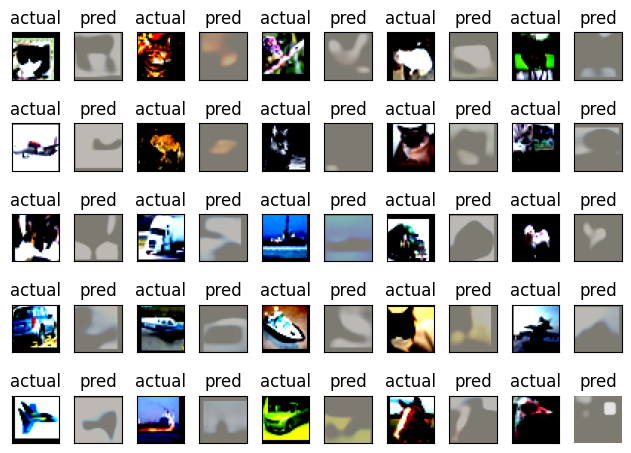

In [17]:
from matplotlib.pyplot import imshow
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

fig,ax = plt.subplots(5,10)
ax = ax.ravel()
for i in range(50):
    image, label = datamodule2.val_dataset[int(i/2)]
    if i%2 == 0:
        ax[i].imshow(image.permute(1, 2, 0))
        ax[i].set_title("actual")
        ax[i].set( xticks=[], yticks=[])
    else:
        image2 = torch.full((1, 32, 32), 0)
        for row in range(32):
            image2[0][row][(label + 1)%10] = 1
        final_img = torch.cat((image, image2), 0)
        final_img = final_img.unsqueeze(0)
        #final_img = np.array(final_img)
        with torch.no_grad():
            vae.eval()
            x_hat, z, mu, log_var = vae.VAE(final_img)

        normalize = cifar10_normalization()
        mean, std = np.array(normalize.mean), np.array(normalize.std)
        img = (x_hat[0][0:3].permute(1, 2, 0).detach().numpy()) * std + mean
        ax[i].imshow(img)
        ax[i].set_title("pred")
        ax[i].set( xticks=[], yticks=[])
   
plt.axis('off')
plt.tight_layout()
plt.xlabel('Misclassified Images')
plt.ylabel('Loss')
plt.legend("Incorrect Prediction/Actual Label")
plt.show()